In [1]:
import pvdeg
from pvdeg import TEST_DATA_DIR
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

### Creating a Chamber Setpoint File

This set of functions is used to create pseudo-weather files that specify the environmental conditions in a chamber as opposed to outdoors. To start, a simplified set of environmental chamber setpoints must be created. Some example profiles that are commonly used in the PV industry or that come from standardized testing regimes are located in the folder, 'put in the folder name ' in the form of encoded *.csv files. 

The *.csv files are structed as...

If you combine sequences together, remember to remove the first line corresponding to the initial conditions.

Using preset sequences we could do the following. Or these could refer to variables in the pvdeg namespace.  
`sequence=['wet_hot', 'wet_hot', 'dry_hot', 'cold_superwet']`  

This would just be one loop but because of convienent python syntax we could do the following to repeat the sequence twice.  `sequence * 2`

## Defining A Chamber Test Environment

We want to load a csv containing chamber setpoints. This will define the chamber's temperature, relative humidity, irradiance, etc. for every timestep.

### Schema for creating a setpoints CSV file 

Our csv will contain a header row to define each column with a name (cannot contain spaces).  
The `Chamber` class was designed to be easily extensible so you can add your own setpoint columns for arbitrary setpoints but there are a few rules.

### Required Columns

`step_length`, `step_divisions`, `RAMPS`

The CSV must contain the above columns (both in units of minutes). These determine how long a step will last and how many datapoints we will have within the step. We also need to define a RAMP for each setpoint column we include. This requires us to add a second column for each setpoint which is named `<setpoint>_ramp` where `<setpoint>` is swapped for the name of your setpoint (without the angle brackets).

**Examples:**

- We want to include a column for temperature setpoints, this means we need to add a ramp rate in terms of [setpoint_units / min].  
    If we add a column for `wind_speed` setpoints, we will need to add a corresponding column called `wind_speed_ramp`.

- We want columns for `temperature` and `irradiance_340` (irradiance at 340 nm). We will need to add `temperature_ramp` and `irradiance_340_ramp`.  
    Our final column list will look like the following:  
    ```
    ['temperature', 'irradiance_340', 'temperature_ramp', 'irradiance_340_ramp']
    ```

In the constructor we will define the setpoint column names we want to take from the CSV. Say our CSV includes the following column names: `temperature`, `relative_humidity`, `voltage`, `irradiance_340`, `irradiance_300-400`, `irradiance_full`. But we only want to include `temperature`, `relative_humidity`, `irradiance_340`, then we specify this in the `setpoint_names` argument.

Lastly, `skiprows` tells pandas what row indices to skip when reading the CSV. We have units in row 2, which lies at index 1 (Python is zero indexed). So we will skip the row with the units. This works because we put the index inside of a list. If we just pass it the integer then we will skip 1 row, i.e. the row with the column names.



In [2]:
chamber = pvdeg.Chamber(
    fp=os.path.join(TEST_DATA_DIR, "chamber-setpoints.csv"), # use a setpoints file in the test folder
    setpoint_names=["temperature", "relative_humidity", "irradiance_340"],
    skiprows=[1]
)

chamber.setDimensions(length=0.1, width=0.1)
chamber.setAbsorptance(0.05)

,setpoint_temperature,setpoint_relative_humidity,setpoint_irradiance_340
0 days 00:00:00,25.0,50.0,0.0
0 days 00:01:00,90.0,30.0,0.55
0 days 00:02:00,90.0,30.0,0.55
0 days 00:03:00,90.0,30.0,0.55
0 days 00:04:00,90.0,30.0,0.55
...,...,...,...
33 days 07:56:00,85.0,85.0,0.55
33 days 07:57:00,85.0,85.0,0.55
33 days 07:58:00,85.0,85.0,0.55
33 days 07:59:00,85.0,85.0,0.55

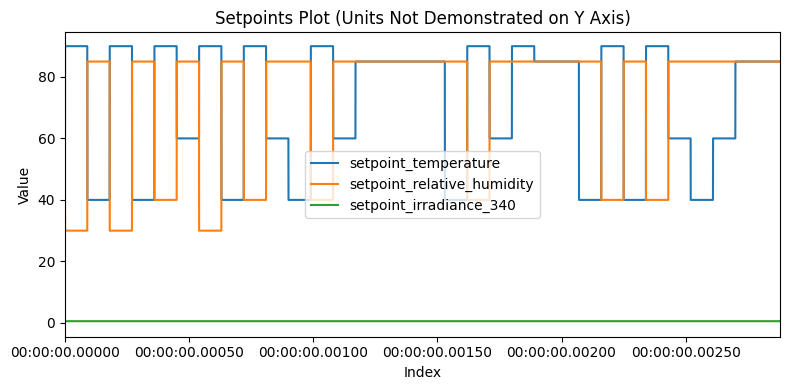

In [3]:
chamber

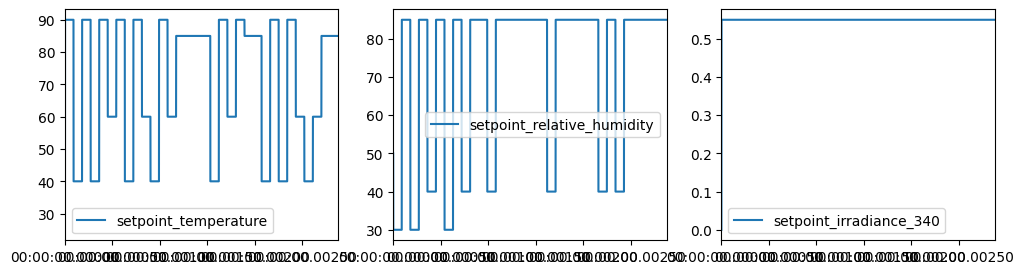

In [4]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

for i, name in enumerate(chamber.setpoints.columns):
    chamber.setpoints[name].plot(ax=axs[i], legend=True)

## Calculating Chamber Conditions

Use `chamber_properties` to calculate the conditions in the chamber at each timestep.

- tau_c : Chamber equilibraiton time [min]
- tau_s : Sample equilibration time [min]
- To_s :   Sample initial temperature [°C]
- Ea_ecap_s : Encapsulant activation energy for solubility [kJ/mol]
- So_encap_s : Encapsulant solubility prefactor [g/cm³]
- encap_num : Encapsulant reference number. This will pull data from the PVDeg library for the Arrhenius solubility and diffusivity calculations. In a conflict, this will override individual entries but does not include the thickness.

### Calculating Chamber Air and Sample Temperature

Use method, `Chamber.calc_temperatures` to calculate the chamber air temperature and the test sample temperature at each point in time. We don't actually need to do this for the following steps but could be useful by itself.

The sample temperature is dependent on air temperature, so we need to calculate air temperature first. The method shown below does this for us but if we want to do it on our own we can use the functions as follows,
- `pvdeg.chamber.air_temperature` 
- `pvdeg.chamber.sample_temperature`

#### Function Arguments

| variable | description |
| --- | --- |
| air_temp_0 | Initial air temperature inside chamber [$\degree C$] | 
| sample_temp_0 | Initial sample temperature inside chamber [$\degree C$] | 
| tau_c | $\tau_C$, thermal equilibration time of chamber air [min] | 
| tau_s | $\tau_S$, thermal equilibration time of test sample [min] | 

In [5]:
chamber.calc_temperatures(
    air_temp_0=25, 
    sample_temp_0=25, 
    tau_c=10, 
    tau_s=15
    )

Calculating GTI...
Saved in self.setpoints as "setpoints_irradiance_full


Text(0.5, 1.0, 'Chamber and Sample Temperatures for First 200 Minutes')

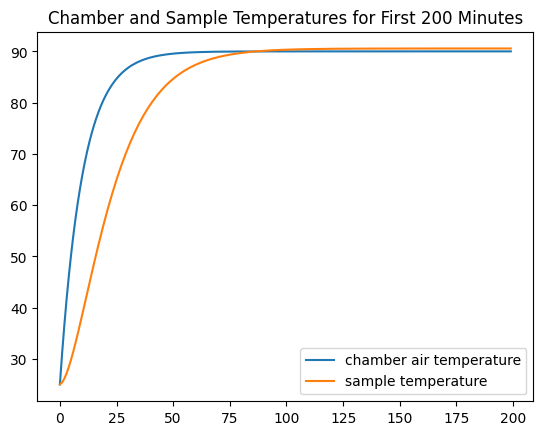

In [6]:
plt.plot(chamber.air_temperature.values[:200], label="chamber air temperature") # inital air temperature
plt.plot(chamber.sample_temperature.values[:200], label="sample temperature")
plt.legend()
plt.title("Chamber and Sample Temperatures for First 200 Minutes")

## Adding Materials To Test Sample

Use the following methods to set sample backsheet material and sample encapsulant material respectively, `Chamber.setBacksheet`, `Chamber.setEncapsulant`. These functions pull in values from the degradation database based on material name.  
*Adding materials coming later, already supported in scenarios*.  

This defines the activation energy, and prefactors for encapsulant diffusivity, encapsulant solubility, and backsheet permeability.

Uses materials from `PVDegradationTools/data/materials.json`.

#### Function Arguments

| variable | description |
| --- | --- |
| id | name of the material to include from `materials.json` | 
| thickness | thickness of the backsheet/encapsulant [mm] |


In [7]:
# These are pulling in the oxygen values
# the materials json contains the oxygen values from the degradation database NOT WATER

# chamber.setBacksheet(id='ST504', thickness=0.5) # PET
# chamber.setEncapsulant(id='EVA', thickness=0.1) # EVA

chamber.setBacksheet(pvdeg_file="O2permeation", key="OX002", thickness=0.5) # ST504/PET1
chamber.setEncapsulant(pvdeg_file="O2permeation", key="OX003", thickness=0.1)  # EVA

## Chamber Conditions

To calculate the weather conditions inside of the chamber during the period of setpoints use the `Chamber.chamber_conditions` method. This will produce a dataframe containing setpoints for each relevant parameter, chamber air temperature, water vapor pressure and dew point conditions for each timestep.

This will be useful when we want to apply the simulated chamber data to other `PVDeg` functions from other modules.

#### Function Arguments
| variable | description |
| --- | --- |
| tau_c | $\tau_C$, thermal equilibration time of chamber air [min] | 
| air_temp_0 | Initial air temperature inside of chamber [$\degree C$] | 


In [8]:
chamber_df = chamber.chamber_conditions(tau_c=10, air_temp_0=25)
chamber_df

,setpoint_temperature,setpoint_relative_humidity,setpoint_irradiance_340,setpoint_irradiance_full,Air Temperature,Water Vapor Pressure,Dew Point
0 days 00:00:00,25.0,50.0,0.0,0.0,25.000000,1.586603,13.799419
0 days 00:01:00,90.0,30.0,0.55,1096.460463,31.185568,1.378942,11.721883
0 days 00:02:00,90.0,30.0,0.55,1096.460463,36.782501,1.895397,16.501222
0 days 00:03:00,90.0,30.0,0.55,1096.460463,41.846816,2.494778,20.827960
0 days 00:04:00,90.0,30.0,0.55,1096.460463,46.429197,3.167122,24.738060
...,...,...,...,...,...,...,...
33 days 07:56:00,85.0,85.0,0.55,1096.460463,85.000000,49.353716,81.111387
33 days 07:57:00,85.0,85.0,0.55,1096.460463,85.000000,49.353716,81.111387
33 days 07:58:00,85.0,85.0,0.55,1096.460463,85.000000,49.353716,81.111387
33 days 07:59:00,85.0,85.0,0.55,1096.460463,85.000000,49.353716,81.111387


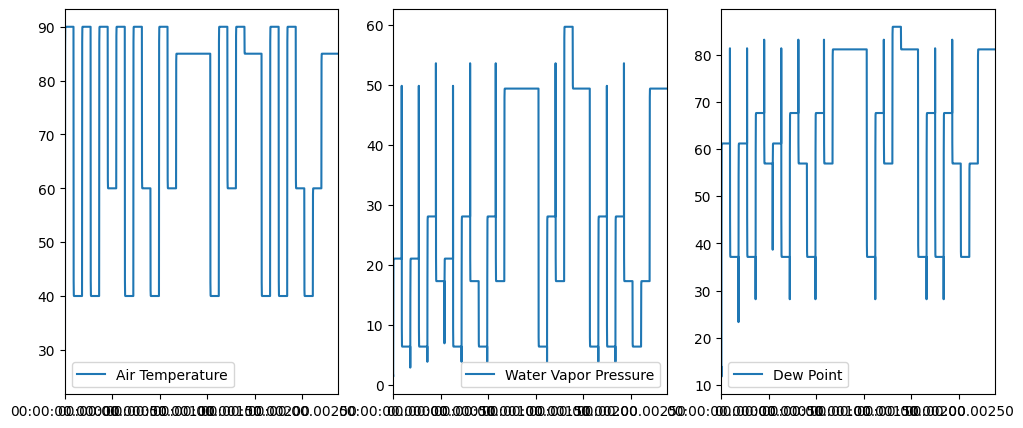

In [9]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,5))

for i, name in enumerate(chamber_df.columns):
    if ("setpoint" not in name):
        chamber_df[name].plot(ax=axs[i - 4], legend=True)

## Sample Conditions

To calculate the conditions of the sample in the chamber test we can use the method below. This must be run after the `chamber_conditions` calculation.

| variable | description |
| --- | --- |
| sample_temp_0 | Initial sample temperature inside chamber [$\degree C$] | 
| tau_s | $\tau_S$, thermal equilibration time of test sample [min] | 
| n_steps | integer to control numerical stability for backside encapsulant moisture calculation, higher = better numerical stability, slower |

In [10]:
sample_df = chamber.sample_conditions(
    sample_temp_0=25,
    tau_s=15,
    n_steps=20
)
sample_df

,Sample Temperature,Sample Relative Humidity,Equilibrium Encapsulant Water,Back Encapsulant Moisture,Relative Humidity Internal Cells Backside
0 days 00:00:00,25.000000,50.000000,0.000083,0.000083,50.000000
0 days 00:01:00,25.398926,42.402850,0.000071,0.000083,49.475518
0 days 00:02:00,26.169636,55.600423,0.000095,0.000083,48.706962
0 days 00:03:00,27.217253,68.677156,0.000120,0.000083,47.825648
0 days 00:04:00,28.492838,80.759486,0.000145,0.000084,46.900538
...,...,...,...,...,...
33 days 07:56:00,85.566708,83.170236,0.000428,0.000428,83.170236
33 days 07:57:00,85.566708,83.170236,0.000428,0.000428,83.170236
33 days 07:58:00,85.566708,83.170236,0.000428,0.000428,83.170236
33 days 07:59:00,85.566708,83.170236,0.000428,0.000428,83.170236


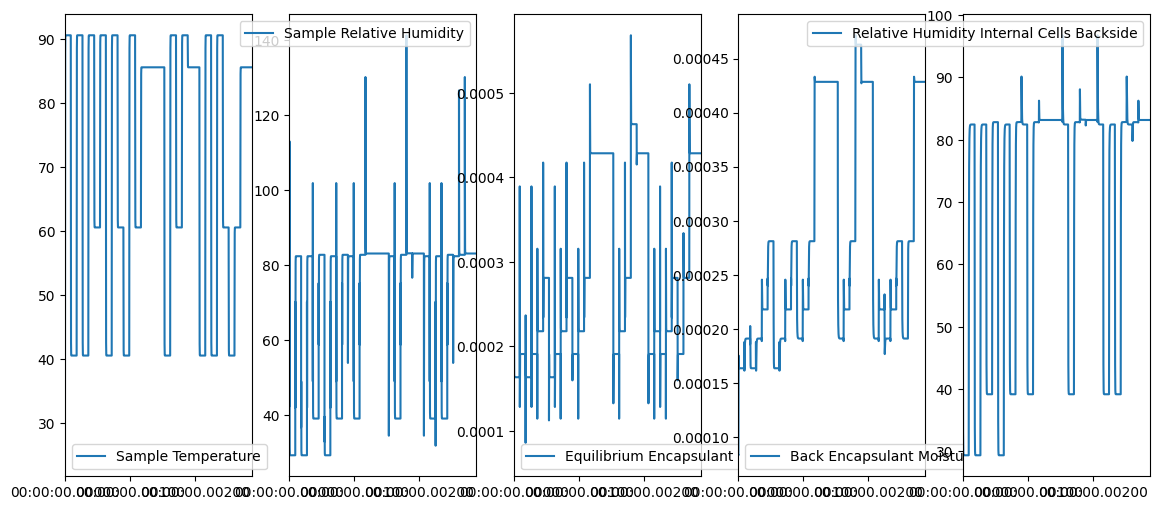

In [11]:
f, axs = plt.subplots(nrows=1, ncols=5, figsize=(14,6))

for i, name in enumerate(sample_df.columns):
    sample_df[name].plot(ax=axs[i], legend=True)

## Extracting Irradiance
The method below will get us the Global Tilt Irradiance (GTI) of a module at 37 degrees tilt within our chamber. 

We can convert back to POA components with pvlib. This requires making some assumptions about location/azimuth to determine how we divide the POA irradiance into subcomponents (GHI, DHI, DNI). *Add example...*

In [12]:
chamber.setpoints["setpoint_irradiance_full"]

0 days 00:00:00             0.0
0 days 00:01:00     1096.460463
0 days 00:02:00     1096.460463
0 days 00:03:00     1096.460463
0 days 00:04:00     1096.460463
                       ...     
33 days 07:56:00    1096.460463
33 days 07:57:00    1096.460463
33 days 07:58:00    1096.460463
33 days 07:59:00    1096.460463
33 days 08:00:00    1096.460463
Name: setpoint_irradiance_full, Length: 48001, dtype: object

### Front of Cell Water Concentration Profile

Using a numerical solution to the 2D diffusion equation we can determine the water concentration in the pannel at a given time. Each 2D matrix in the result represents nodes on the cell in 2d at a timestep in the input dataframe. We are using a right triangle that represents $1/8$ of the area of the module.

$C^{P+1}_{m,n} = \frac{D \Delta t}{(\Delta X)^2}(C^{P}_{m+1,n} + C^{P}_{m-1,n} + C^{P}_{m, n+1} + C^{P}_{m, n-1}) + [1 - 4 \frac{D \Delta t}{(\Delta X)^2}]C^{P}{m,n}$


*A note on numerical stability*: for the diffusion equation we must keep the `Fourier number` below 0.25. The easiest way to do this is by increasing the number of substeps calculated at each timestep. Increasing `n_steps` will decrease the likelihood of the algorithm "blowing up". This parameter is problematic because the time complexity of the algorithm is influenced at O(n^2) time. Meaning for each increase of 1 in the parameter we will see a quadratic increase in the runtime. To improve this issue, we can decrease the number of timesteps, for example only running every 1 out of 5 entries in the timeseries inputs, and run more substeps.

We could dynamically determine if we need a larger number of substeps using binary search but this is not implemented yet.

In [13]:
kelvin_temps = chamber.sample_temperature + 273.15 # convert to kelvin

res = pvdeg.diffusion.module_front(
    time_index=chamber.back_encapsulant_moisture.index[:2400],
    backsheet_moisture=chamber.back_encapsulant_moisture[:2400],
    sample_temperature=kelvin_temps[:2400],

    # we should be pulling these from the chamber attributes but this works for demonstration purposes
    # these are the water values from the degredation database
    eva_diffusivity_ea=0.395, # eV
    Dif=0.13, # prefactor diffusion, cm^2/s, this is not the right value for prefactor
    n_steps=20 # numerical stability issues at small timesteps, the bigger the timestep difference in the timedelta index being passed, the better
)

KeyboardInterrupt: 

## Viewing Our Results

The cell below shows the end state of the water concentration in the front of the module. And the following cell renders an interactive animation showing concentrations in the cell at each timestep. note: the animation requires plotly, not included in pvdeg depedency list. install using `pip install plotly`.

In [ ]:
plt.matshow(res[-2], cmap='viridis')

In [ ]:
import plotly.subplots
import plotly.graph_objects as go

fig = plotly.subplots.make_subplots(rows=1,cols=1)
frame = go.Frame(data=go.Heatmap(z=res[0], colorscale='Viridis'))
frames = [go.Frame(data=go.Heatmap(z=res[i], colorscale='Viridis'), name=str(i)) for i in range(res.shape[0])]

fig.add_trace(go.Heatmap(z=res[0], colorscale='Viridis'))

fig.update_layout(
    updatemenus=[{
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate'}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }],
    sliders=[{
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Frame:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [
            {
                'args': [[str(k)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate'}],
                'label': str(k),
                'method': 'animate'
            } for k in range(res.shape[0])
        ]
    }]
)

# Add the frames to the figure
fig.frames = frames

# Show the figure
fig.show()

### Optional: Save plot

Save the interactive plot to an HTML file which can be reopened and interacted with later.

In [ ]:
import plotly.io as pio
pio.write_html(fig, 'diffusion_plot.html', auto_open=True)